In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy

In [2]:
from scipy.stats import norm

sigma = 10
cost = 1
# high value of planning: sigma=30, c=0.01
# medium value of planning: sigma=28, c=1.00
# low value of planning: sigma=1, c=4.00

def make_env(sigma=sigma, cost=cost, n=4):
    d = norm(0, sigma)
    vals = np.linspace(-1.5*sigma, 1.5*sigma, n)
    delta = vals[1] - vals[0]
    bins = np.array((-np.inf, *(vals[1:] - delta/2), np.inf))
    probs = np.diff(d.cdf(bins))
    reward = Categorical(vals, probs)
    # vals = [-5, -1, 1, 5]
    # probs = [.1, .4, .4, .1]
    # reward = Categorical(vals, probs)
    return MouselabEnv([4,1,2], reward=reward, cost=cost,
                       ground_truth=[0, *reward.sample(16)])

def make_envs(seed=0, n=50):
    np.random.seed(seed)
    return [make_env() for _ in range(n)]

envs = make_envs(5)
TERM = envs[0].term_action

In [3]:
import json
def save_envs(envs):
    data = [{'stateRewards': e.ground_truth.tolist()} for e in envs]
    with open('../experiments/exp1/static/json/med_cost.json', 'w+') as f:
        json.dump(data, f)
        
save_envs(envs)

In [4]:
from policies import MouselabPolicy
from skopt import gp_minimize
bounds = [ (-30., 30.) ] * 5
agent = Agent()

def evaluate(policy, envs):
    def run_env(policy, env):
        agent.register(policy)
        agent.register(env)
        tr = agent.run_episode()
        return {'util': tr['return'],
                'observations': len(tr['actions']) - 1}
    return pd.DataFrame(run_env(policy, env) for env in envs)

def optimize(envs):    
    def objective(theta):
        theta = np.array(theta)
        util = evaluate(MouselabPolicy(theta), envs).util.mean()
        print(theta.round(3), util)
        return - util
    
    return gp_minimize(objective, bounds, n_calls=50, random_state=123)

In [5]:
agent = Agent()
result = optimize(envs)

[ 11.788 -12.832 -16.389   3.079  13.168] -3.8
[ -4.614  28.846  11.09   -1.144  -6.473] 8.86
[ -9.409  13.743  -3.686 -26.419  -6.117] -3.8
[ 14.28  -19.05  -19.473   1.893   1.91 ] -3.8
[  8.064  20.966  13.467   6.661  13.347] 5.24
[-10.622  -8.293 -16.304 -12.377   7.859] -3.8
[-24.474  -3.978  -4.148  -0.379  -4.45 ] -3.8
[-11.264  -4.419  23.603  26.65    0.11 ] 11.06
[  7.437 -23.063 -10.963  -5.11   21.979] -3.8
[-14.973  -1.018  29.134   1.169   6.774] 5.24
[  3.67   20.721  12.445   8.642   7.664] 5.2
[  4.268  21.361  12.423   7.843   7.394] 5.24
[-15.87   21.294  18.925  10.145 -20.36 ] 7.6
[ 30.    -30.     20.526  30.     -3.184] 6.12
[-13.633  -2.756  23.564  26.963   0.151] 9.38
[-30.     14.923  22.268  30.      4.144] 5.2
[ -8.68   -6.217  23.421  28.027  -0.365] 11.28
[ -5.903  -8.339  22.926  30.     -2.12 ] 11.66
[ -4.762  -9.3    22.797  30.     -3.116] 11.58
[ -4.802  -8.878  23.514  30.     -2.032] 11.66
[ -5.272  -8.503  23.724  30.     -1.809] 11.94
[ -4.109  

In [6]:
print(np.array(result.x).round(5).tolist())

[-4.54043, -8.17798, 27.42567, 29.25199, -1.9919]


In [7]:
# agent.register(MouselabPolicy([1,1,1,1]))
# agent.register(e)
# agent.run_episode()

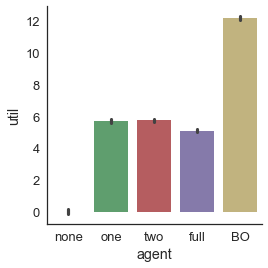

In [8]:
def data():
    policies = {
        'BO': MouselabPolicy(result.x),
        'full': FixedPlanPolicy(range(1, TERM+1)),
        'none': FixedPlanPolicy([TERM]),
        'one': FixedPlanPolicy([1, 5, 9, 13, TERM]),
        'two': FixedPlanPolicy([1, 2, 5, 6, 9, 10, 13, 14, TERM]),
    }
    def dfs():
        for name, policy in policies.items():
            df = evaluate(policy, envs=make_envs(12, 1000))
            df['agent'] = name
            # print('======= {} ======='.format(name))
            # print('Observations: {:.3f}'.format(df.observations.mean() - 2))
            # print('Return: {:.3f}'.format(df.util.mean() / sigma))
            yield df
    return pd.concat(dfs())
    
df = data()
big_df = pd.concat([df] * 50)
sns.factorplot('agent', 'util', data=big_df, 
               order=['none', 'one', 'two', 'full', 'BO'], 
               kind='bar')

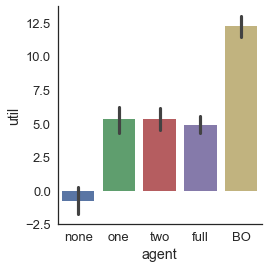

In [12]:
sns.factorplot('agent', 'util', data=df, 
               order=['none', 'one', 'two', 'full', 'BO'], 
               kind='bar')